In [2]:
# from nd2_combine import tools
# from segment import seg
# from droplet_growth import multiwell
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
# import logging
# import os
# import math
import pandas as pd
# import re
# from skimage.morphology import convex_hull_image
# from skimage.transform import rotate
# from scipy.ndimage import gaussian_filter1d as gf
# from scipy.interpolate import interp1d
import seaborn as sns
from tifffile import imread
import json
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

In [63]:
def subsample_intensity_profile(values, n_samples=10, sigma=10, plot=False):
    '''
    Subsamples 1D curve.
    1. Cut off zero values
    2. Smooth with `sigma`
    3. Intepolate using vector with `n_samples` spots
    
    Return:
    -------
    Subsampled values
    '''
    r_profile = np.array(values, 'float')
    rf_profile = r_profile[r_profile > 0]
    rfs_profile = gf(rf_profile, sigma)
    full_vector = np.arange(len(rfs_profile))
    approx = interp1d(full_vector, rfs_profile)
    vector = np.linspace(0, len(rfs_profile)-1, n_samples, endpoint=True)
    subsample = approx(vector)
    
    if plot:
        plt.plot(rf_profile)
        plt.plot(rfs_profile)
        plt.plot(vector, subsample, '.r')
        plt.show()
    return subsample / subsample.max()


In [98]:
paths = glob('/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie//*.tif')
paths

['/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie/MAX_3-2.tif',
 '/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie/MAX_2.tif',
 '/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie/MAX_1.tif',
 '/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie/MAX_2-1.tif',
 '/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie/MAX_6-2.tif',
 '/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie/MAX_4-2.tif']

In [103]:
crops = list(map(imread, paths))

In [104]:
def get_profile(crop):
    profile = (m:=crop.mean(axis=0)) - m.min()
    return profile # / profile.max()

In [105]:
def get_profiles(multi_channel_crop, channels=['BRA', 'EN1'], bins=30, plot=True):
    
    vector = np.linspace(-.5, .5, bins)
    data = {'bins': vector, }
    profiles = {l: subsample_intensity_profile(get_profile(c), n_samples=bins) for l, c in zip(channels, multi_channel_crop)}
    out = pd.DataFrame({**data, **profiles})
    if plot:
        fig, ax = plt.subplots(1, len(multi_channel_crop))
        [a.imshow(c) for a, c in zip(ax, multi_channel_crop)]
        [a.set_title(c) for a, c in zip(ax, channels)]
        plt.show()
        
        [plt.plot('bins', ch, data=out, label=ch) for ch in channels]
        plt.legend()
        plt.show()
    return out

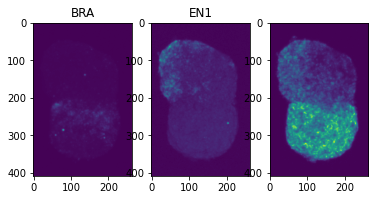

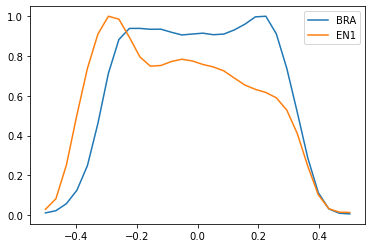

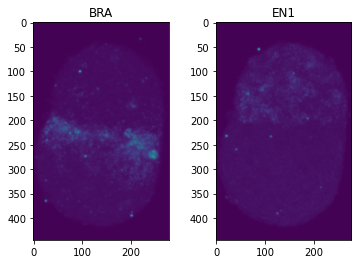

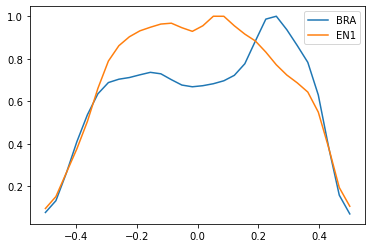

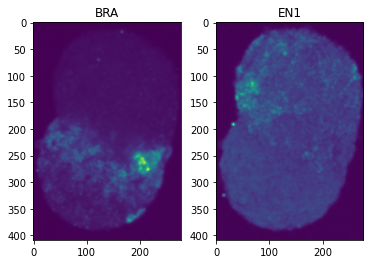

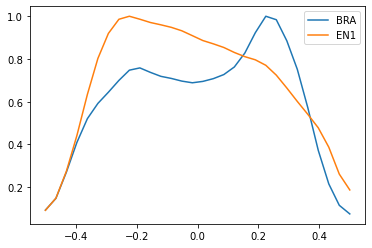

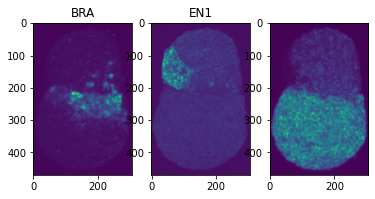

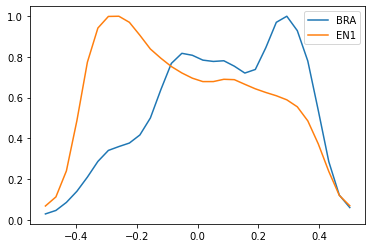

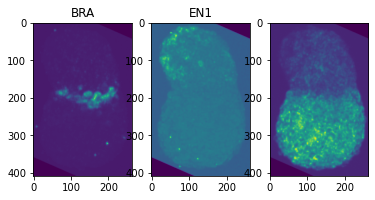

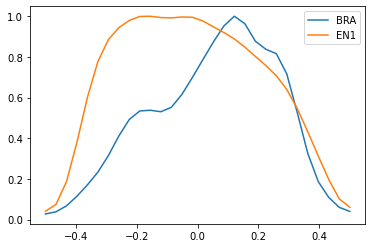

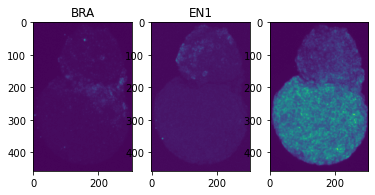

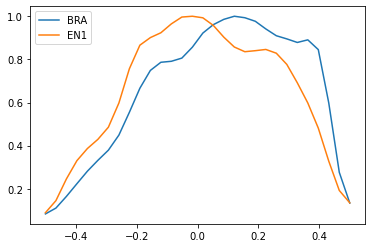

In [106]:
profiles = list(map(get_profiles, crops))

In [107]:
df_profiles = pd.concat(profiles)

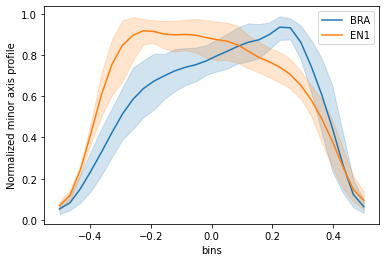

In [111]:
sns.lineplot(data=df_profiles, x='bins', y='BRA')
sns.lineplot(data=df_profiles, x='bins', y='EN1')
plt.legend(['BRA', 'EN1'])
plt.ylabel('Normalized minor axis profile')
plt.savefig('/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie/fish_minor_profiles.pdf')

In [110]:
df_profiles.to_csv('/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO/FISH_T_EN1_NANOG/en1_nANOG_T/crops copie//profiles_binned.csv', index=None)